Импорт библиотек

In [1]:
from typing import Optional, Tuple, Literal, Iterable
from abc import abstractmethod, ABC
import copy
import torch
from torch import Tensor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from src.nn import BayesianModule, BayesianLinear, BayesianSequential, BayesianBinaryClassifier


def gini_score(
    y_true,
    y_score,
) -> np.float64:
    return (roc_auc_score(y_true=y_true, y_score=y_score) - 0.5) * 2

Чтение данных и разбиение на трейн и тест

In [2]:
df = pd.read_csv("data/Cancer_Data.csv").set_index("id")
df = df.loc[:, df.notna().all(axis=0)]
df["is_M"] = (df["diagnosis"] == "M").astype("int")
df = df.drop("diagnosis", axis=1)
x = df.drop("is_M", axis=1)
y = df["is_M"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

Обучение модели

In [3]:
x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()

In [4]:
model = BayesianBinaryClassifier(
    dim_in=x_train.shape[-1],
    dims_hidden=[30]*3,
    f_act="LeakyReLU",
    backbone="Perceptrone",
    # backbone="ResNet",
    batch_norm=True,
    batch_penalty=True,
).cuda()

,loss,p_item_average
epoch,,
0,160.573532,0.000000e+00
1,116.121460,0.000000e+00
2,97.183083,6.221765e-43
3,85.164108,1.032043e-37
4,71.478439,9.063756e-32
...,...,...
5995,0.132986,8.754777e-01
5996,0.146592,8.636463e-01
5997,0.122135,8.850287e-01


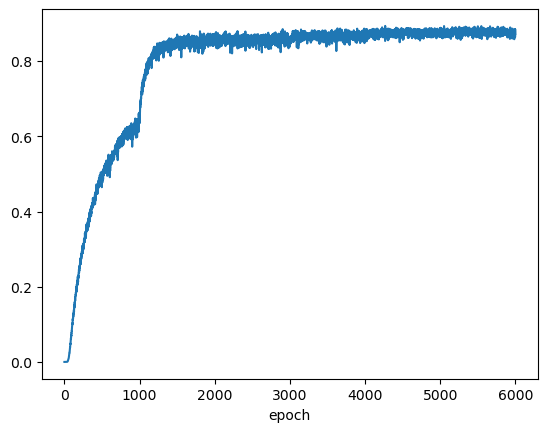

In [5]:
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=1_000,
    lr=0.05,
)
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=2_000,
    lr=0.01,
)
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=1_000,
    lr=0.005,
)
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=1_000,
    lr=0.001,
)
model.fit(
    x=x_train_tensor,
    y=y_train_tensor,
    num_epoch=1_000,
    lr=0.0001,
)
model.df_metrics["p_item_average"].plot()
model.df_metrics

Предсказание на тесте.
Каждый объект прогоняется через модель 5000

In [6]:
model = model.eval().cpu()
x_test_tensor = torch.from_numpy(x_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).view(-1, 1).float()

y_pred_test_tensor = torch.nn.Sigmoid()(model.eval()(x_test_tensor.expand(5000, *x_test_tensor.shape)))
y_pred_test = y_pred_test_tensor.cpu().detach().numpy()

Оценка результата работы на тесте

In [7]:
accuracy_score(
    y_true=y_test.values,
    y_pred=y_pred_test.mean(axis=0).reshape(-1) > 0.5,
)

0.9824561403508771

Сравнение модели со случайным лесом

In [8]:
model_forest = RandomForestClassifier(n_estimators=500)
model_forest.fit(X=x_train, y=y_train)
y_pred_test_forest = model_forest.predict(X=x_test)

accuracy_score(
    y_true=y_test.values,
    y_pred=model_forest.predict(X=x_test),
)

0.956140350877193

Сравнение модели с бустингом

In [9]:
model_boost = GradientBoostingClassifier()
model_boost.fit(X=x_train, y=y_train)

accuracy_score(
    y_true=y_test.values,
    y_pred=model_boost.predict(X=x_test),
)

0.9736842105263158

Сравнение модели с перцептроном

In [10]:
model_mlp = MLPClassifier(hidden_layer_sizes=[30] * 3, activation="relu", max_iter=1000)
model_mlp.fit(X=x_train, y=y_train)

accuracy_score(
    y_true=y_test.values,
    y_pred=model_mlp.predict(X=x_test),
)

0.9649122807017544